In [22]:
#Importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as mpl

Files already downloaded and verified


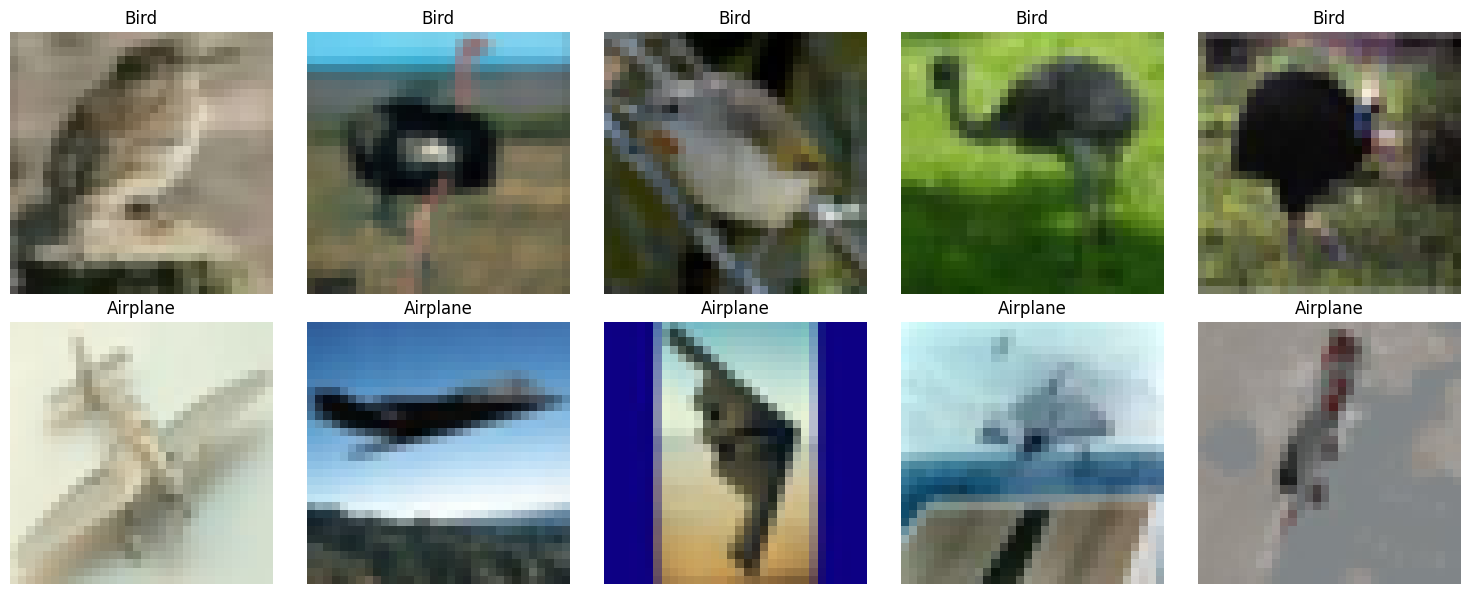

In [23]:
#Displaying 5 random images of Bird and Plane
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
bird_indices = [i for i, label in enumerate(train_dataset.targets) if label == 2]
plane_indices = [i for i, label in enumerate(train_dataset.targets) if label == 0]
bird_random_indices = np.random.choice(bird_indices, 5, replace=False)
plane_random_indices = np.random.choice(plane_indices, 5, replace=False)
fig, axes = mpl.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(bird_random_indices):
    img, label = train_dataset[idx]
    img = img.permute(1, 2, 0)
    axes[0, i].imshow(img)
    axes[0, i].set_title("Bird")
    axes[0, i].axis('off')

for i, idx in enumerate(plane_random_indices):
    img, label = train_dataset[idx]
    img = img.permute(1, 2, 0)
    axes[1, i].imshow(img)
    axes[1, i].set_title("Airplane")
    axes[1, i].axis('off')

mpl.tight_layout()
mpl.show()


In [24]:
#Downloading the data
class_mapping = {0: 1, 2: -1}
class TwoClassCIFAR10(Dataset):
    def __init__(self, dataset, classes_to_include, class_mapping):
        self.dataset = dataset
        self.classes_to_include = classes_to_include
        self.class_mapping = class_mapping
        self.indices = [i for i, label in enumerate(self.dataset.targets) if label in self.classes_to_include]
        self.targets = [self.dataset.targets[i] for i in self.indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        image, label = self.dataset[self.indices[idx]]
        label = self.class_mapping[label]
        return image, label

transform = transforms.Compose([transforms.ToTensor()])
train_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset_full = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_dataset = TwoClassCIFAR10(train_dataset_full, classes_to_include=[0, 2], class_mapping=class_mapping)
test_dataset = TwoClassCIFAR10(test_dataset_full, classes_to_include=[0, 2], class_mapping=class_mapping)


Files already downloaded and verified
Files already downloaded and verified


In [25]:
#Extracting the required data and dividing it into train and test data
def extract_data(dataset):
    data_list = []
    label_list = []
    for i in range(len(dataset)):
        img, label = dataset[i]
        data_list.append(img.numpy())
        label_list.append(label)
    data = np.array(data_list)
    labels = np.array(label_list)
    return data, labels

X_train, y_train = extract_data(train_dataset)
X_test, y_test = extract_data(test_dataset)
num_train_samples = X_train.shape[0]
num_test_samples = X_test.shape[0]
X_train_flat = X_train.reshape(num_train_samples, -1)
X_test_flat = X_test.reshape(num_test_samples, -1)
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_test_flat = scaler.transform(X_test_flat)


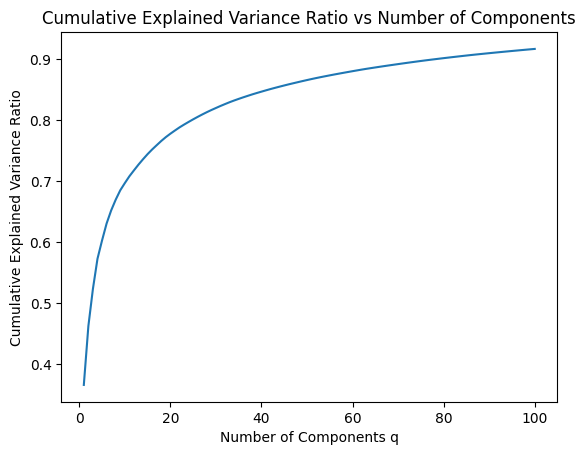

In [26]:
#Plotting the cumulative explained variance ratio as asked in the presentation file
n_components = 100
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
mpl.figure()
mpl.plot(range(1, n_components + 1), cumulative_explained_variance)
mpl.xlabel('Number of Components q')
mpl.ylabel('Cumulative Explained Variance Ratio')
mpl.title('Cumulative Explained Variance Ratio vs Number of Components')
mpl.show()


In [27]:
#getting the data ready by converting it to required formats and creating batches for epoch runs
y_train_binary = (y_train + 1) / 2
y_test_binary = (y_test + 1) / 2
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_binary, dtype=torch.float32)
train_dataset_pca = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_pca = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 64
train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)


In [28]:
#Getting all the dimensions ready for maintaining dimensionality
input_dimension = n_components
hidden_dimension = 50
class Net(nn.Module):
    def __init__(self, input_dimension, hidden_dimension):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dimension, hidden_dimension)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dimension, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze(1)

model = Net(input_dimension=input_dimension, hidden_dimension=hidden_dimension)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
#Training the model by running the epochs and calculating the
#train loss, train accuracy, test loss and test accuracy
num_epochs = 20
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader_pca:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) >= 0.5
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_accuracy = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    model.eval()
    running_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader_pca:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) >= 0.5
            correct_test += (preds == labels).sum().item()
            total_test += labels.size(0)

    epoch_loss = running_loss / total_test
    epoch_accuracy = correct_test / total_test
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')


Epoch 1/20, Train Loss: 0.5132, Train Accuracy: 0.7591, Test Loss: 0.4154, Test Accuracy: 0.8245
Epoch 2/20, Train Loss: 0.4032, Train Accuracy: 0.8312, Test Loss: 0.3844, Test Accuracy: 0.8355
Epoch 3/20, Train Loss: 0.3707, Train Accuracy: 0.8468, Test Loss: 0.3695, Test Accuracy: 0.8455
Epoch 4/20, Train Loss: 0.3432, Train Accuracy: 0.8637, Test Loss: 0.3603, Test Accuracy: 0.8490
Epoch 5/20, Train Loss: 0.3214, Train Accuracy: 0.8721, Test Loss: 0.3582, Test Accuracy: 0.8485
Epoch 6/20, Train Loss: 0.3008, Train Accuracy: 0.8813, Test Loss: 0.3494, Test Accuracy: 0.8530
Epoch 7/20, Train Loss: 0.2850, Train Accuracy: 0.8887, Test Loss: 0.3485, Test Accuracy: 0.8550
Epoch 8/20, Train Loss: 0.2660, Train Accuracy: 0.9001, Test Loss: 0.3434, Test Accuracy: 0.8540
Epoch 9/20, Train Loss: 0.2538, Train Accuracy: 0.9040, Test Loss: 0.3428, Test Accuracy: 0.8570
Epoch 10/20, Train Loss: 0.2409, Train Accuracy: 0.9098, Test Loss: 0.3530, Test Accuracy: 0.8490
Epoch 11/20, Train Loss: 0.22

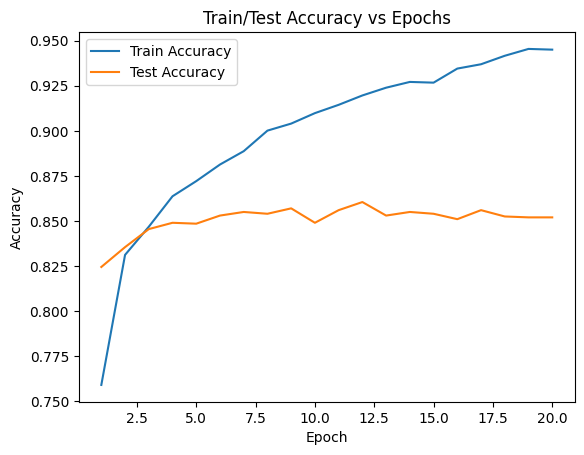

In [30]:
#Plotting the Accuracy vs 1 hyperparameter (In my case I have taken epoch as the hyperparameter)
mpl.figure()
mpl.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
mpl.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
mpl.xlabel('Epoch')
mpl.ylabel('Accuracy')
mpl.title('Train/Test Accuracy vs Epochs')
mpl.legend()
mpl.show()


Train Accuracy goes to 95% as the epochs progress but the Test Accuracy remains around 85% after 5 epochs.

In [31]:
#Evaluating the accuracy of the model and individual accuracy for each class of datasest
model.eval()
correct_total = 0
total_samples = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader_pca:
        outputs = model(inputs)
        preds = torch.sigmoid(outputs) >= 0.5
        correct_total += (preds == labels).sum().item()
        total_samples += labels.size(0)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.numpy())

overall_accuracy = correct_total / total_samples
print(f'Overall Accuracy: {overall_accuracy:.4f}')

class_names = {0: 'bird', 1: 'airplane'}
for class_label in [0, 1]:
    idx = np.array(all_labels) == class_label
    correct = (np.array(all_preds)[idx] == np.array(all_labels)[idx]).sum()
    total = idx.sum()
    class_accuracy = correct / total
    print(f'Accuracy for class {class_names[class_label]}: {class_accuracy:.4f}')



Overall Accuracy: 0.8520
Accuracy for class bird: 0.8560
Accuracy for class airplane: 0.8480


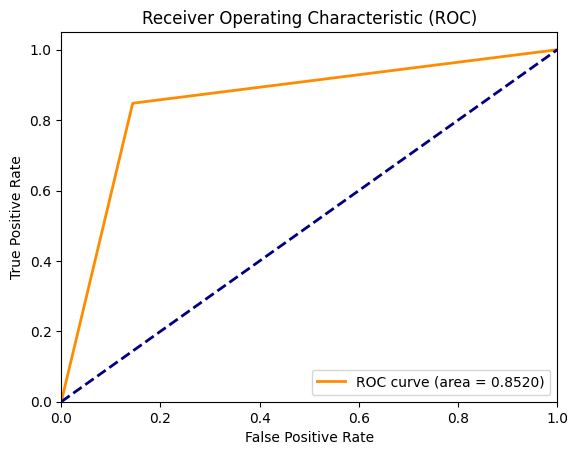

In [32]:
#Plotting the ROC curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

mpl.figure()
mpl.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
mpl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
mpl.xlim([0.0, 1.0])
mpl.ylim([0.0, 1.05])
mpl.xlabel('False Positive Rate')
mpl.ylabel('True Positive Rate')
mpl.title('Receiver Operating Characteristic (ROC)')
mpl.legend(loc='lower right')
mpl.show()


In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 20
batch_size = 64
learning_rate = 0.001
reg_strength = 0.001
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset_full = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset_full = datasets.CIFAR10(root='./data', train=False, transform=transform)
class_airplane = 0
class_bird = 2
def filter_classes(dataset):
    idx = np.isin(dataset.targets, [class_airplane, class_bird])
    dataset.data = dataset.data[idx]
    dataset.targets = np.array(dataset.targets)[idx]
    dataset.targets = np.where(np.array(dataset.targets) == class_airplane, -1, 1)
    return dataset

train_dataset = filter_classes(train_dataset_full)
test_dataset = filter_classes(test_dataset_full)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


Files already downloaded and verified


In [34]:
#Getting the CNN ready with appropriate functions and information such as padding, filter size etc
class CNN(nn.Module):
    def __init__(self, reg_strength=0.0):
        super(CNN, self).__init__()
        self.reg_strength = reg_strength
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 8 * 8, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def l2_regularization(self):
        l2_loss = torch.tensor(0., requires_grad=True)
        for param in self.parameters():
            l2_loss = l2_loss + torch.norm(param, 2)
        return self.reg_strength * l2_loss


In [35]:
model = CNN(reg_strength=reg_strength).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [36]:
#Defining a function for calculatee the accuracy
def compute_accuracy(model, loader):
    model.eval()
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            predicted = (torch.sigmoid(outputs) > 0.5).float() * 2 - 1
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
    accuracy = correct / total
    return accuracy, y_true, y_pred


In [39]:
#Running the epochs for CNN and calculating training and testing accuracy
train_accuracies = []
test_accuracies = []
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss += model.l2_regularization()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_accuracy, _, _ = compute_accuracy(model, train_loader)
    test_accuracy, _, _ = compute_accuracy(model, test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}')


Epoch [1/20], Train Accuracy: 0.5245, Test Accuracy: 0.5255
Epoch [2/20], Train Accuracy: 0.5245, Test Accuracy: 0.5255
Epoch [3/20], Train Accuracy: 0.5245, Test Accuracy: 0.5260
Epoch [4/20], Train Accuracy: 0.5245, Test Accuracy: 0.5260
Epoch [5/20], Train Accuracy: 0.5245, Test Accuracy: 0.5265
Epoch [6/20], Train Accuracy: 0.5245, Test Accuracy: 0.5260
Epoch [7/20], Train Accuracy: 0.5245, Test Accuracy: 0.5265
Epoch [8/20], Train Accuracy: 0.5245, Test Accuracy: 0.5265
Epoch [9/20], Train Accuracy: 0.5245, Test Accuracy: 0.5265
Epoch [10/20], Train Accuracy: 0.5246, Test Accuracy: 0.5265
Epoch [11/20], Train Accuracy: 0.5247, Test Accuracy: 0.5265
Epoch [12/20], Train Accuracy: 0.5247, Test Accuracy: 0.5265
Epoch [13/20], Train Accuracy: 0.5246, Test Accuracy: 0.5265
Epoch [14/20], Train Accuracy: 0.5247, Test Accuracy: 0.5265
Epoch [15/20], Train Accuracy: 0.5246, Test Accuracy: 0.5265
Epoch [16/20], Train Accuracy: 0.5246, Test Accuracy: 0.5265
Epoch [17/20], Train Accuracy: 0.

In [40]:
#Displaying accuracy for each class and overall accuracy
test_accuracy, y_true, y_scores = compute_accuracy(model, test_loader)
y_true_bin = np.array(y_true)
y_true_bin = np.where(y_true_bin == -1, 0, 1)
y_pred_bin = (np.array(y_scores) > 0).astype(int)
cm = confusion_matrix(y_true_bin, y_pred_bin)
class0_accuracy = cm[0, 0] / (cm[0, 0] + cm[0, 1])
class1_accuracy = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(f'\nFinal Test Accuracy: {test_accuracy:.4f}')
print('\nPer class accuracy:')
print(f"Class -1 (airplane): {class0_accuracy:.4f}")
print(f"Class 1 (bird): {class1_accuracy:.4f}")





Final Test Accuracy: 0.5265

Per class accuracy:
Class -1 (airplane): 0.9910
Class 1 (bird): 0.0620


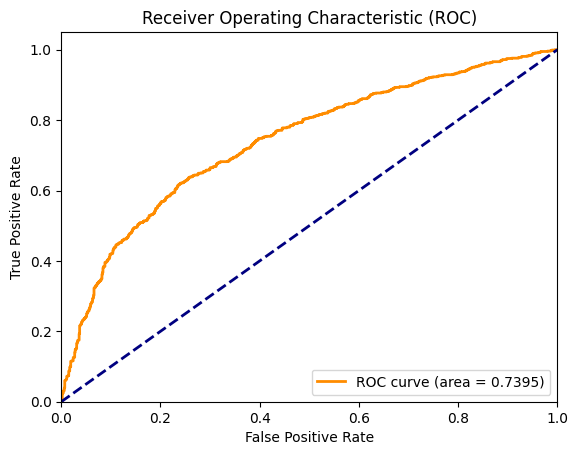

In [41]:
#Plotting the ROC curve for CNN
fpr, tpr, thresholds = roc_curve(y_true_bin, y_scores)
roc_auc = auc(fpr, tpr)
mpl.figure()
mpl.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
mpl.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
mpl.xlim([0.0, 1.0])
mpl.ylim([0.0, 1.05])
mpl.xlabel('False Positive Rate')
mpl.ylabel('True Positive Rate')
mpl.title('Receiver Operating Characteristic (ROC)')
mpl.legend(loc='lower right')
mpl.show()


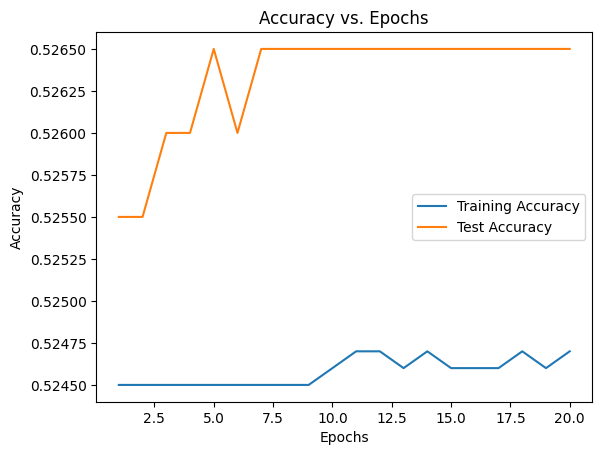

In [42]:
#Plotting the Accuracy vs Epochs
#Will vary after every run
mpl.figure()
mpl.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
mpl.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
mpl.xlabel('Epochs')
mpl.ylabel('Accuracy')
mpl.title('Accuracy vs. Epochs')
mpl.legend()
mpl.show()


Regularization Strength: 0.0001, Train Accuracy: 0.5390, Test Accuracy: 0.5425
Regularization Strength: 0.001, Train Accuracy: 0.5326, Test Accuracy: 0.5295
Regularization Strength: 0.01, Train Accuracy: 0.5173, Test Accuracy: 0.5150
Regularization Strength: 0.1, Train Accuracy: 0.5381, Test Accuracy: 0.5420


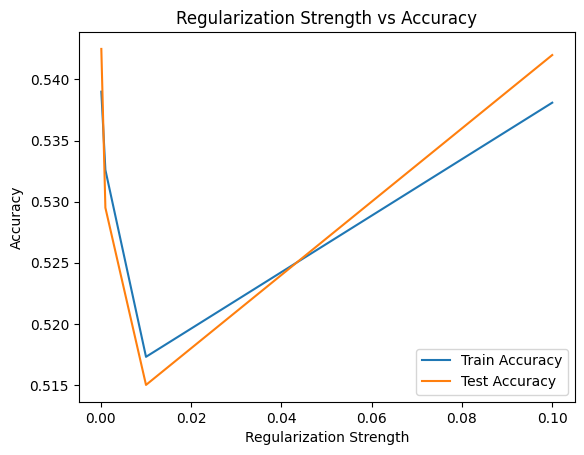

In [43]:
#Plotting the Accuracy vs 1 hyperparameter plot (In this case I have taken regularization strength as the comparing hyperparameter, instead of epoch as in the earlier graph)
def train_with_reg_strength(reg_strength):
    model = CNN(reg_strength=reg_strength).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(5):
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device).float()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss += model.l2_regularization()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    train_accuracy, _, _ = compute_accuracy(model, train_loader)
    test_accuracy, _, _ = compute_accuracy(model, test_loader)
    return train_accuracy, test_accuracy

reg_strengths = [0.0001, 0.001, 0.01, 0.1]
train_accs = []
test_accs = []
for reg in reg_strengths:
    train_acc, test_acc = train_with_reg_strength(reg)
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    print(f'Regularization Strength: {reg}, Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}')
mpl.figure()
mpl.plot(reg_strengths, train_accs, label='Train Accuracy')
mpl.plot(reg_strengths, test_accs, label='Test Accuracy')
mpl.xlabel('Regularization Strength')
mpl.ylabel('Accuracy')
mpl.title('Regularization Strength vs Accuracy')
mpl.legend()
mpl.show()


It can be noted here that in the beginning the accuracy reduce but as the strength increased accuracy kept getting better